# TinyNoiseGru Training Notebook

Train a lightweight, causal GRU-based Noise Power Spectrum Estimator suitable for real-time hearing-aid applications.

**Architecture Design:**
- Based on TinyGRUVAD architecture (proven lightweight & causal)
- Outputs noise power spectrum (mel bands) instead of binary VAD
- ~2k parameters for efficient on-device deployment
- Frame-level noise estimation with causal processing

**Target Application:**
- Real-time noise estimation for hearing-aid speech enhancement
- Works with Wiener filtering, Spectral Subtraction.
- Replaces traditional minimum statistics noise estimation

In [328]:
#!pip install -r ../../requirements.txt

In [329]:
# %% ------------------------- Cell 1: Imports & Setup ------------------------
import sys
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
import torchaudio, numpy as np, random
from tqdm.notebook import tqdm

SEED = 0
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

current_dir = Path.cwd()
repo_root = current_dir.parent.parent
sys.path.insert(0, str(repo_root / "src"))

print("Repo root:", repo_root)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# helper utils
from utils.audio_dataset_loader import (
    load_ears_dataset, load_wham_dataset, load_noizeus_dataset,
    create_audio_pairs, preprocess_audio
)

Repo root: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85
Using device: cpu


In [330]:
# %% ------------------------- Cell 2: Global Plot Settings -------------------------
import matplotlib.pyplot as plt

# Set global plot parameters
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

print("[INFO] Global plot settings applied: DPI=400, Font=Times New Roman 18pt")

[INFO] Global plot settings applied: DPI=400, Font=Times New Roman 18pt


In [ ]:
# ============ CELL 3: TinyNoiseGru - ADD INVERSE MEL ============
class TinyNoiseGru(nn.Module):
    """Lightweight GRU-based Noise Power Spectrum Estimator.
    
    Works in mel-space internally, outputs raw FFT bins (inverse mel transform).
    """
    def __init__(self, input_dim=32, hidden_dim=24, dropout=0.1, n_fft=256, sample_rate=16000):
        super().__init__()
        
        # Input features are [log-mel + delta] = 2 * input_dim
        feature_dim = input_dim * 2
        
        # Causal depthwise conv
        self.pre = nn.Conv1d(feature_dim, feature_dim, kernel_size=3, padding=0, groups=4)
        self.norm = nn.LayerNorm(feature_dim)
        
        # Two GRU layers
        self.gru1 = nn.GRU(feature_dim, hidden_dim, batch_first=True)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

        # Output layer: predict in mel-space
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.drop = nn.Dropout(dropout)
        
        # ===== NEW: Inverse Mel Transform =====
        self.n_fft = n_fft
        self.sample_rate = sample_rate
        self.n_mels = input_dim
        
        # Create mel-scale transform (for getting mel filterbank)
        mel_transform = torchaudio.transforms.MelScale(
            n_mels=input_dim, 
            sample_rate=sample_rate, 
            n_stft=n_fft // 2 + 1
        )
        
        # Extract mel filterbank matrix and TRANSPOSE it
        # mel_transform.fb is (n_mels, n_fft//2+1)
        # We need (n_fft//2+1, n_mels) so that (B,T,n_mels) @ (n_mels, n_fft//2+1) = (B,T,n_fft//2+1)
        mel_fb = mel_transform.fb  # Transpose to (n_fft//2+1, n_mels)
        self.register_buffer('mel_fb', mel_fb)
        
    def forward(self, x, h1=None, h2=None):
        """
        Args:
            x: Input features (B, T, F) where F = 2*input_dim (log-mel + delta)
        
        Returns:
            noise_est_fft: Estimated noise in FFT-space (B, T, n_fft//2+1) LINEAR SCALE
            (h1, h2): Updated hidden states
            confidence: Confidence score (B, T, 1)
        """
        x = x.transpose(1,2)  # (B,F,T)
        
        # Causal padding
        k = self.pre.kernel_size[0] if isinstance(self.pre.kernel_size, (list, tuple)) else self.pre.kernel_size
        pad_left = k - 1
        x = F.pad(x, (pad_left, 0))
        
        # Depthwise conv + normalization
        x = self.pre(x).transpose(1,2)  # (B,T,F)
        x = self.norm(x)
        
        # Two-stage GRU temporal modeling
        out1, h1 = self.gru1(x, h1)
        out1 = self.drop(out1)
        
        out2, h2 = self.gru2(out1, h2)
        out2 = self.drop(out2)

        # Predict in mel-space (LOG SCALE)
        noise_est_mel_log = self.fc(out2)  # (B, T, n_mels)
        
            # Convert to LINEAR scale in mel-space
        noise_est_mel_linear = torch.exp(noise_est_mel_log)  # (B, T, n_mels)

        # Inverse Mel Transform: mel → FFT
        noise_est_fft = torch.matmul(noise_est_mel_log, self.mel_fb)  # (B, T, n_fft//2+1)

        # Clamp to prevent negative values and NaNs
        noise_est_fft = noise_est_fft.clamp_min(1e-8)

        # Confidence score
        confidence = 1.0 / (1.0 + torch.std(noise_est_mel_log, dim=-1, keepdim=True))

        # # Convert to LINEAR scale in mel-space
        # noise_est_mel_linear = torch.exp(noise_est_mel_log)  # (B, T, n_mels)
        
        # # ===== NEW: Inverse Mel Transform =====
        # # noise_est_mel_linear: (B, T, n_mels)
        # # mel_fb: (n_mels, n_fft//2+1)
        # # Output: (B, T, n_fft//2+1)
        # # Use @ operator which handles batch dimensions correctly

        # noise_est_fft = noise_est_mel_linear @ self.mel_fb.T  # Shape: (B, T, n_fft//2+1)
        
        # # Clamp to prevent negative values and NaNs
        # noise_est_fft = noise_est_fft.clamp_min(1e-8)

        # noise_est_fft = torch.matmul(noise_est_mel_linear, self.mel_fb.T)  # [B, T, 257]
        
        # confidence = 1.0 / (1.0 + torch.std(noise_est_mel_log, dim=-1, keepdim=True))

        return noise_est_fft, (h1, h2), confidence

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @torch.no_grad()
    def estimate_noise_streaming(self, features, hidden=None):
        """Single-frame streaming inference.
        
        Args:
            features: (1, 1, 2*input_dim) single frame features
            hidden: Previous hidden states (h1, h2)
        
        Returns:
            noise_fft: (1, 1, n_fft//2+1) noise spectrum in FFT-space LINEAR SCALE
            hidden: Updated hidden states
        """
        noise_fft, hidden, _ = self.forward(features, *hidden if hidden else (None, None))
        return noise_fft, hidden



In [332]:
# %% ------------------------- Cell 4: Load Datasets --------------------------
max_pairs = 200
noise_files = load_wham_dataset(repo_root, mode="train", max_files=max_pairs)
clean_files = load_ears_dataset(repo_root, mode="train")
train_pairs = create_audio_pairs(noise_files, clean_files)
print(f"Train pairs: {len(train_pairs)}")

noise_val = load_wham_dataset(repo_root, mode="validation", max_files=30)
clean_val = load_ears_dataset(repo_root, mode="validation")
val_pairs = create_audio_pairs(noise_val, clean_val)
print(f"Val pairs: {len(val_pairs)}")

# Load TEST set (for final evaluation - never used during training)
noise_test = load_wham_dataset(repo_root, mode="test", max_files=30)
clean_test = load_ears_dataset(repo_root, mode="test")
test_pairs = create_audio_pairs(noise_test, clean_val)
print(f"Test pairs: {len(test_pairs)}")
print("\n [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!")

Limited WHAM dataset to 200 files for train mode
Created 200 audio pairs
Train pairs: 200
Limited WHAM dataset to 30 files for validation mode
Created 30 audio pairs
Val pairs: 30
Limited WHAM dataset to 30 files for test mode
Created 30 audio pairs
Test pairs: 30

 [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!


In [333]:
# %% ------------------------- Cell 5: Feature Extraction & Ground Truth -------------------------

def extract_noise_estimation_features(noisy_wave, noise_wave, fs, n_bands=32, frame_len=0.008, hop_len=0.004):
    """Extract features and ground truth for noise estimation training.
        
    References:
    - Cohen & Berdugo (2001) - "Noise estimation by minima controlled recursive averaging"
    - Gerkmann & Hendriks (2012) - "Unbiased MMSE-based noise power estimation"
    - Xu et al. (2014) - "Regression approach to speech enhancement"
    
    Args:
        noisy_wave: Noisy input signal (clean speech + noise)
        noise_wave: Pure noise signal (ground truth)
        fs: Sample rate (typically 16000 Hz)
        n_bands: Number of mel bands (default: 32)
        frame_len: Frame length in seconds (default: 0.008 = 8ms)
        hop_len: Hop length in seconds (default: 0.004 = 4ms)
    
    Returns:
        feats: (1, T, 2*n_bands) feature tensor [log-mel + delta]
        targets: (1, T, n_bands) ground truth noise power spectrum
    """
    # Convert to mono: handle both stereo and mono inputs
    if noisy_wave.dim() > 1 and noisy_wave.shape[0] > 1:
        noisy_wave = noisy_wave.mean(dim=0)
    elif noisy_wave.dim() > 1:
        noisy_wave = noisy_wave[0]
    
    if noise_wave.dim() > 1 and noise_wave.shape[0] > 1:
        noise_wave = noise_wave.mean(dim=0)
    elif noise_wave.dim() > 1:
        noise_wave = noise_wave[0]

    min_len = min(noisy_wave.shape[0], noise_wave.shape[0])
    noisy_wave = noisy_wave[:min_len]
    noise_wave = noise_wave[:min_len]

    n_fft, hop = int(fs*frame_len), int(fs*hop_len)
    win = torch.hann_window(n_fft)

    def power_spectrum(w): 
        # center=False -> causal framing (no future samples)
        spec = torch.stft(w, n_fft, hop, window=win, center=False, return_complex=True)
        return spec.abs()**2

    mel_transform = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)
    
    # ============ FEATURES: Extract from NOISY audio (realistic input) ============
    mel_noisy = mel_transform(power_spectrum(noisy_wave)).clamp_min(1e-8)
    log_mel = torch.log(mel_noisy.T + 1e-8)  # (T, n_bands)
    
    # Delta features: temporal derivative (captures noise evolution)
    delta = torch.zeros_like(log_mel)
    delta[1:] = log_mel[1:] - log_mel[:-1]
    
    feats = torch.cat([log_mel, delta], 1).unsqueeze(0)  # (1, T, 2*n_bands)
    
    # ============ TARGETS: Extract from PURE NOISE (ground truth) ============
    mel_noise = mel_transform(power_spectrum(noise_wave))  # (n_bands, T)
    # noise_power = mel_noise.T.clamp_min(1e-8)  # (T, n_bands)
    # targets = noise_power.unsqueeze(0)  # (1, T, n_bands)
    
    # # NEW: LOG scale (match input features!)
    log_noise_power = torch.log(mel_noise.T.clamp_min(1e-8) + 1e-8)  # (T, n_bands)

    # # Standardize targets (critical for training stability)
    # log_noise_mean = log_noise_power.mean()
    # log_noise_std = log_noise_power.std()
    # log_noise_normalized = (log_noise_power - log_noise_mean) / (log_noise_std + 1e-8)

    # targets = log_noise_normalized.unsqueeze(0)  # (1, T, n_bands)
    targets = log_noise_power.unsqueeze(0)  # (1, T, n_bands)

    # Ensure features and targets have same temporal dimension
    min_frames = min(feats.size(1), targets.size(1))
    feats = feats[:, :min_frames, :]
    targets = targets[:, :min_frames, :]

    # IMPORTANT: Return normalization stats for inverse transform later
    return feats, targets

In [334]:
# %% ------------------------- Cell 6: Dataset & Loader -----------------------
class NoiseEstimationDataset(torch.utils.data.Dataset):
    """Dataset for training TinyNoiseGru.
    
    Each sample:
    - Loads a clean speech file and a noise file
    - Mixes them at a random SNR
    - Extracts features from noisy mixture
    - Extracts ground truth from pure noise
    """
    def __init__(self, pairs, target_sr=16_000, snr_range=(-5, 15)):
        self.pairs = pairs
        self.sr = target_sr
        self.snr_range = snr_range
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        noise_path, clean_path = self.pairs[idx]
        snr = random.uniform(*self.snr_range)
        
        # preprocess_audio returns: clean_wave, noise_wave, noisy_wave, fs
        clean_wave, noise_wave, noisy_wave, fs = preprocess_audio(
            Path(clean_path), Path(noise_path), self.sr, snr, None
        )
        
        # Extract features and targets
        feats, targets = extract_noise_estimation_features(noisy_wave, noise_wave, fs)
        
        return feats.squeeze(0), targets.squeeze(0)


# def collate_pad_noise(batch):
#     """Collate function for variable-length sequences.
    
#     Pads all sequences to the maximum length in the batch.
#     """
#     feats, targets = zip(*batch)
#     lengths = [f.size(0) for f in feats]
#     T_max = max(lengths)
#     F_dim = feats[0].size(1)
#     T_dim = targets[0].size(1)

#     # T_max = 257
#     # F_dim = 257
#     # T_dim = 516
    
#     X = torch.zeros(len(batch), T_max, F_dim)
#     Y = torch.zeros(len(batch), T_max, T_dim)
    
#     # for i, (f, t) in enumerate(zip(feats, targets)):
#     #     X[i, :f.size(0), :f.size(1)] = f
#     #     Y[i, :t.size(0), :t.size(1)] = t

#     for i, (f, t) in enumerate(zip(feats, targets)):
#         X[i,  :f.size(1)] = f
#         Y[i, :t.size(1)] = t
    
#     return X, Y, torch.tensor(lengths)

def collate_pad_noise(batch):
    """Collate function for variable-length sequences.
    Pads all sequences to the maximum length in the batch.
    """
    feats, targets = zip(*batch)
    lengths = [f.size(0) for f in feats]  # time dimension
    T_max = max(lengths)
    F_dim = feats[0].size(1)
    T_dim = targets[0].size(1)

    X = torch.zeros(len(batch), T_max, F_dim)
    Y = torch.zeros(len(batch), T_max, T_dim)

    for i, (f, t) in enumerate(zip(feats, targets)):
        X[i, :f.size(0), :] = f
        Y[i, :t.size(0), :] = t

    return X, Y, torch.tensor(lengths)


# Create datasets and loaders
train_ds = NoiseEstimationDataset(train_pairs)
val_ds = NoiseEstimationDataset(val_pairs)

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=8, shuffle=True, 
    collate_fn=collate_pad_noise, pin_memory=True
)
val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=8, 
    collate_fn=collate_pad_noise, pin_memory=True
)

print(f"[INFO] Train batches: {len(train_dl)}")
print(f"[INFO] Val batches: {len(val_dl)}")

[INFO] Train batches: 25
[INFO] Val batches: 4


[INFO] Model parameters: 14,144
[INFO] Frequency weights applied: [0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 1.9033457040786743, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.9516728520393372, 0.95167285203

Epoch 1/50:   0%|          | 0/25 [00:00<?, ?it/s]

Clean speech duration: 11.67s (186732 samples)
Noise duration: 11.70s (187256 samples)
Noise truncated to random frame starting at sample 341
Clean speech duration: 14.03s (224503 samples)
Noise duration: 9.76s (156211 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 7.00s (112020 samples)
Noise duration: 16.35s (261523 samples)
Noise truncated to random frame starting at sample 42773
Clean speech duration: 13.09s (209435 samples)
Noise duration: 11.14s (178224 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 15.70s (251222 samples)
Noise duration: 13.38s (214119 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 13.54s (216631 samples)
Noise duration: 11.32s (181069 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 12.53s (200503 samples)
Noise duration: 14.03s (22446

RuntimeError: mat1 and mat2 shapes cannot be multiplied (26752x32 and 257x32)

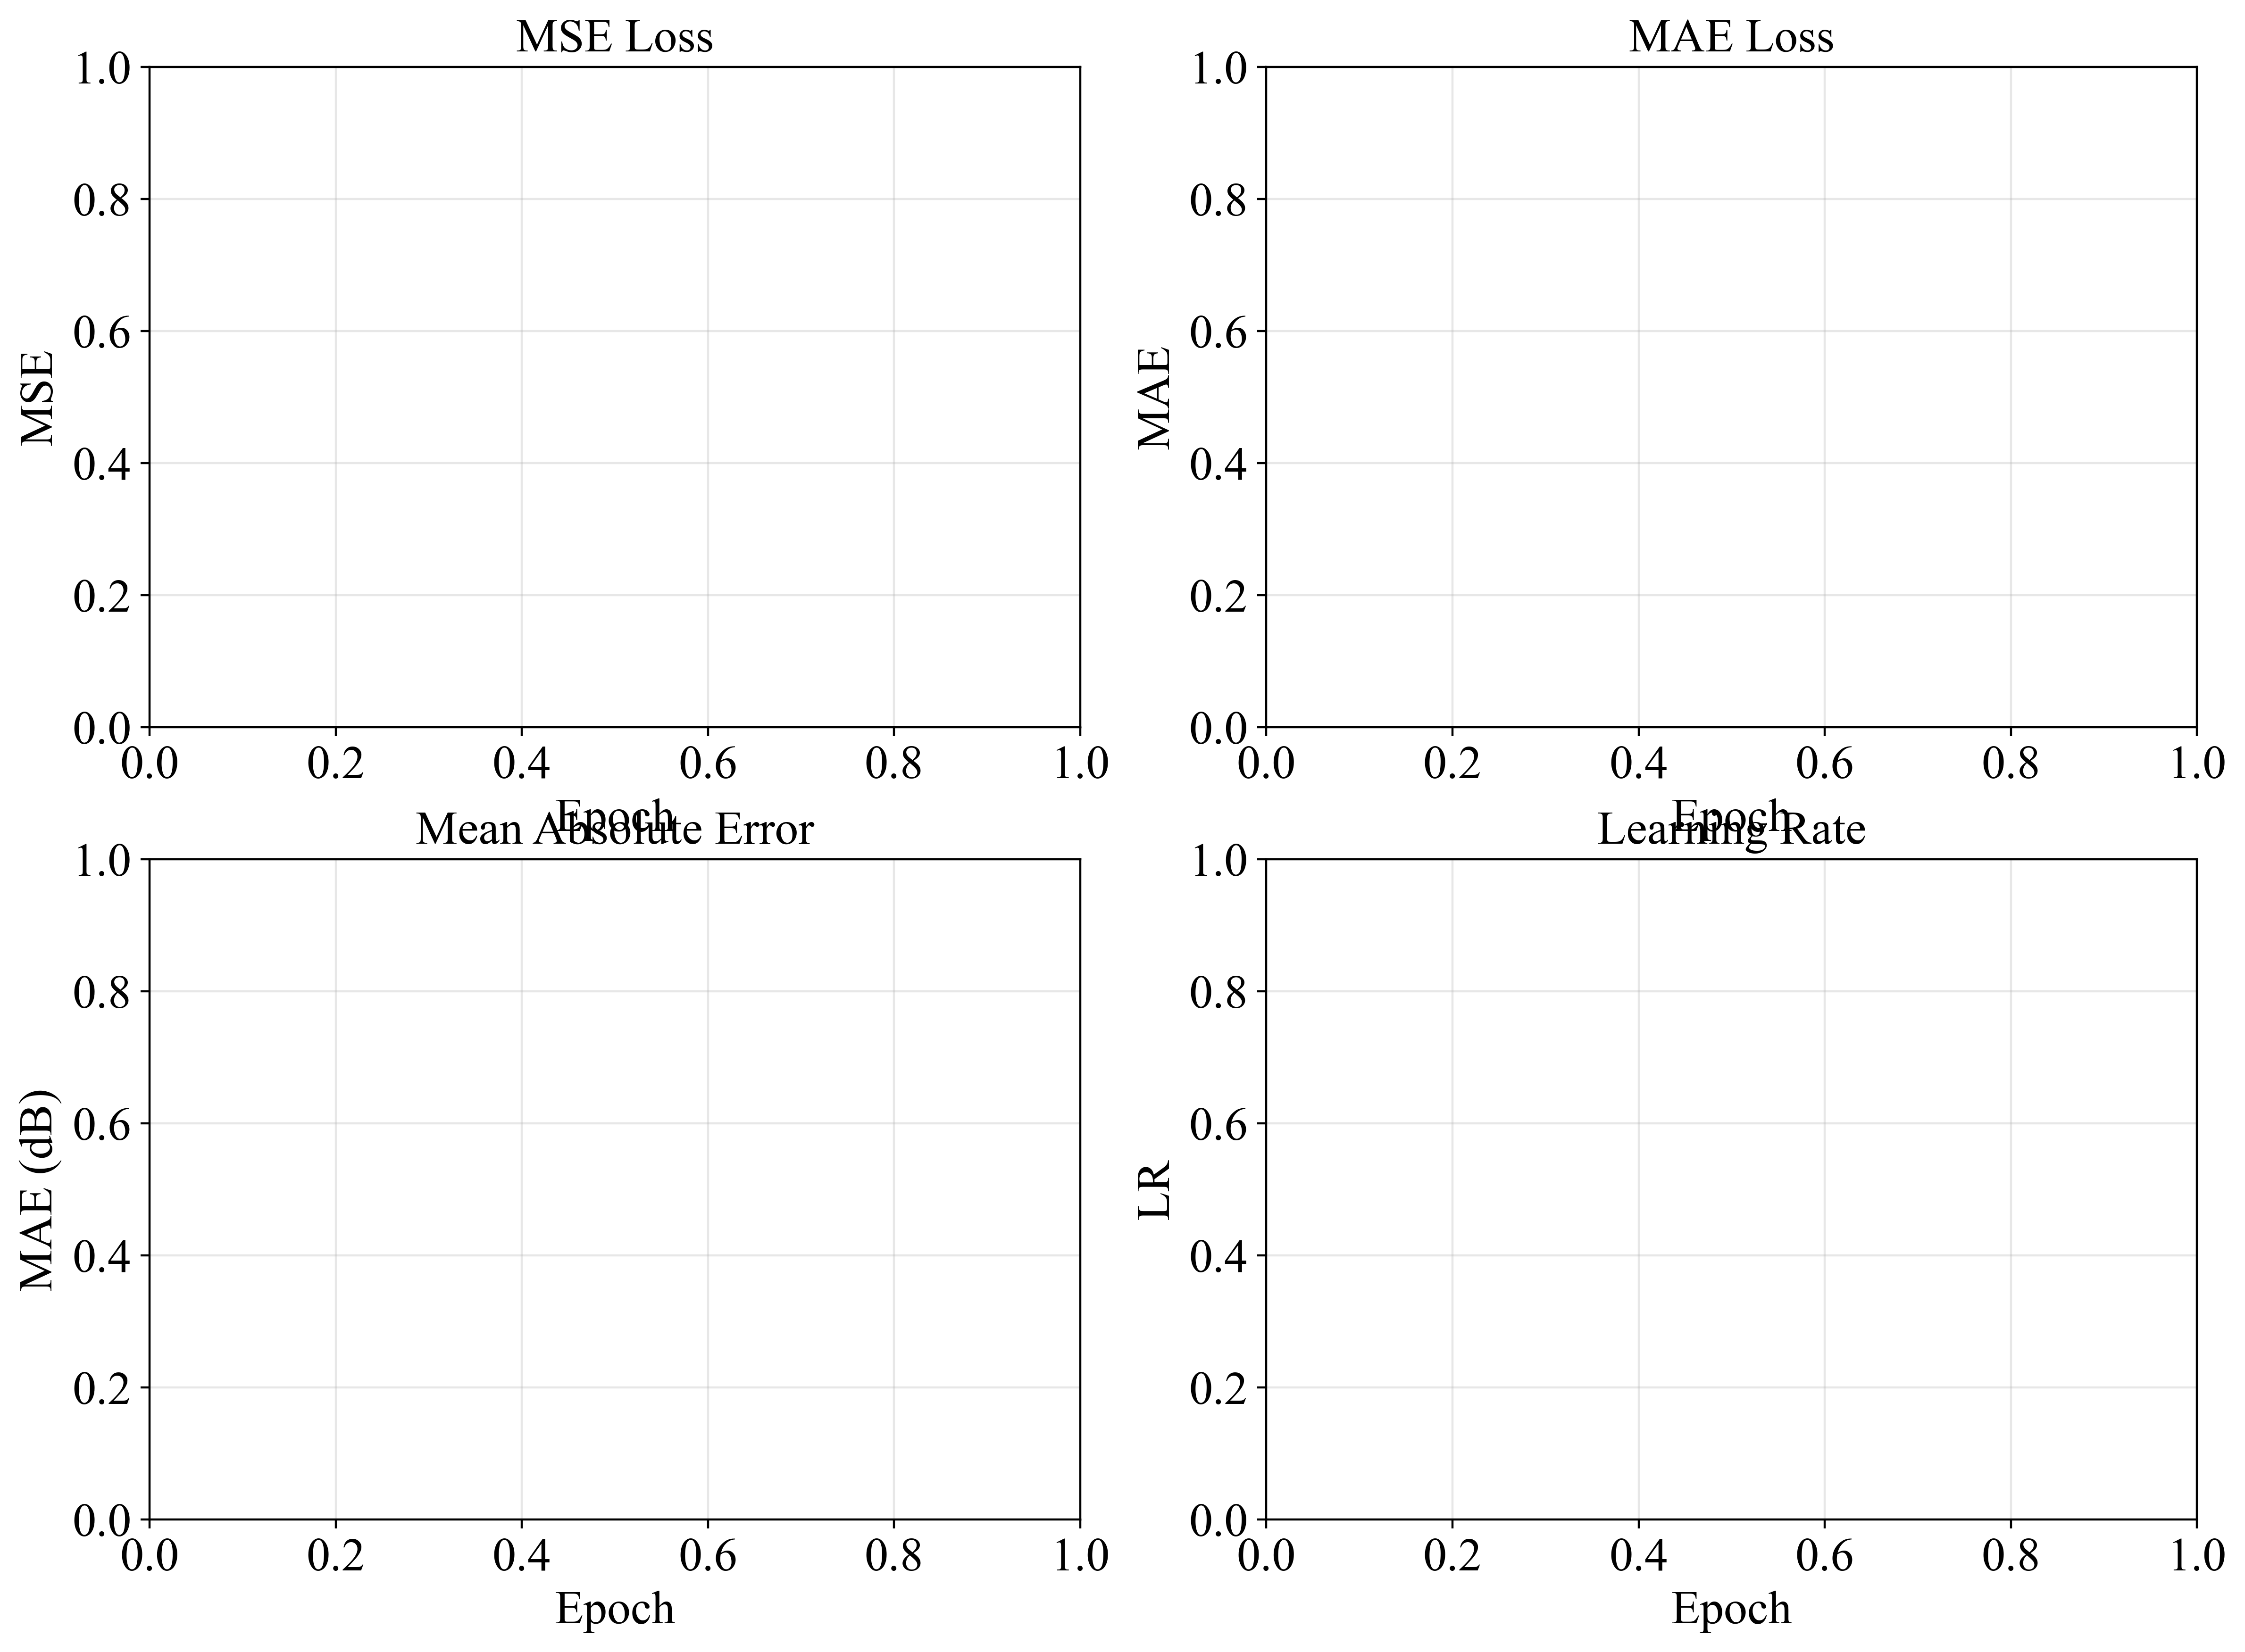

In [335]:
# %% ------------------------- Cell 7: Training Loop -------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import pandas as pd

# Initialize model
N_BANDS = 32  # Number of mel bands
model = TinyNoiseGru(input_dim=N_BANDS, hidden_dim=24, n_fft=512, sample_rate=16000).to(device)
# (n_fft=512 gives 257 FFT bins which is standard; adjust if your audio processing uses different n_fft)
print(f"[INFO] Model parameters: {model.count_parameters():,}")

# Optimizer and scheduler
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

# Loss function: MSE for regression
# Note: We'll compute per-frame loss and average over valid frames
crit = nn.MSELoss(reduction='none')


# CREATE FREQUENCY WEIGHTS (for perceptually-weighted loss)
freq_weights = torch.ones(256, device=device)
freq_weights[3:16] = 2.0  # Weight speech bands (300-3400 Hz) more heavily
freq_weights = freq_weights / freq_weights.sum() * 256  # Normalize
print(f"[INFO] Frequency weights applied: {freq_weights.tolist()}")

# Model saving paths
best_mse = float('inf')
bestPath = repo_root / "models" / "GRU_NoiseEst" / "tiny_noise_gru_best.pth"
bestPath.parent.mkdir(parents=True, exist_ok=True)

# Create directory for checkpoints
models_dir = repo_root / "models" / "GRU_NoiseEst" / "training_checkpoints"
models_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Checkpoint directory: {models_dir}")

# Create directory for training data
training_data_dir = repo_root / "results" / "GRU_NoiseEst" / "training_data"
training_data_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Training data directory: {training_data_dir}")

# Training configuration
num_epochs = 50  # Number of training epochs
early_stop_patience = 20
epochs_without_improvement = 0

# LR warmup function
def lr_warmup(epoch, warmup_epochs=5, base_lr=1e-3):
    """Linear warmup for first few epochs."""
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

# Prepare live plotting
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax_loss, ax_mae, ax_rel, ax_lr = axes.flatten()

ax_loss.set_title("MSE Loss"); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("MSE"); ax_loss.grid(True, alpha=0.3)
ax_mae.set_title("MAE Loss"); ax_mae.set_xlabel("Epoch"); ax_mae.set_ylabel("MAE"); ax_mae.grid(True, alpha=0.3)
#ax_rel.set_title("Relative Error"); ax_rel.set_xlabel("Epoch"); ax_rel.set_ylabel("Rel. Error (%)"); ax_rel.grid(True, alpha=0.3)
ax_rel.set_title("Mean Absolute Error"); ax_rel.set_xlabel("Epoch"); ax_rel.set_ylabel("MAE (dB)"); ax_rel.grid(True, alpha=0.3)
ax_lr.set_title("Learning Rate"); ax_lr.set_xlabel("Epoch"); ax_lr.set_ylabel("LR"); ax_lr.grid(True, alpha=0.3)

# Metrics storage
train_losses, val_losses = [], []
train_mae, val_mae = [], []
train_rel_err, val_rel_err = [], []
lr_history = []

print("="*80)
print("TRAINING: TinyNoiseGru - Lightweight Noise Power Spectrum Estimator")
print(f"Total Epochs: {num_epochs} | Early Stop Patience: {early_stop_patience}")
print("="*80)

for epoch in range(1, num_epochs + 1):
    # Apply LR warmup
    current_lr = lr_warmup(epoch, warmup_epochs=5)
    for param_group in opt.param_groups:
        param_group['lr'] = current_lr
    lr_history.append(current_lr)
    
    # ---------------- Train ----------------
    model.train()
    train_mse_total = 0.0
    train_mae_total = 0.0
    train_rel_total = 0.0
    train_samples = 0
    
    for x, y, lengths in tqdm(train_dl, desc=f"Epoch {epoch}/{num_epochs}", leave=False):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        noise_est, _, _ = model(x)
        
        # Compute loss only on valid (non-padded) frames
        B, T_max = noise_est.size(0), noise_est.size(1)
        mask = (torch.arange(T_max, device=lengths.device)[None, :] < lengths[:, None]).to(device)
        
        # MSE loss
        # loss_per_frame = crit(noise_est, y).mean(dim=-1)  # Average over frequency bins
        # Weighted MSE loss (emphasizes speech-critical frequencies)
        print(f"noise_est{noise_est.shape}")
        print(f"Y{y.shape}")
       
        print(freq_weights)
        loss_per_frame = (crit(noise_est, y) * freq_weights).mean(dim=-1)
        loss = (loss_per_frame * mask).sum() / mask.sum().clamp_min(1.0)

        # Backward pass
        opt.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        opt.step()

        # Add temporal consistency monitoring
        if epoch % 5 == 0:  # Every 5 epochs
            with torch.no_grad():
                # Check prediction variance (should be >0.5 for good tracking)
                pred_std = noise_est.std().item()
                target_std = y.std().item()
                print(f"  [DEBUG] Pred std={pred_std:.3f}, Target std={target_std:.3f}")
                
        # Track metrics
        with torch.no_grad():
            # MSE
            train_mse_total += loss.item() * mask.sum().item()
            
            # MAE
            mae_per_frame = torch.abs(noise_est - y).mean(dim=-1)
            train_mae_total += (mae_per_frame * mask).sum().item()
            
            # Relative error: |pred - true| / true
            rel_err = torch.abs(noise_est - y)  
            train_rel_total += (rel_err.mean(dim=-1) * mask).sum().item()
            
            train_samples += mask.sum().item()
    
    # Average training metrics
    train_mse = train_mse_total / train_samples
    train_mae_epoch = train_mae_total / train_samples
    train_rel_epoch = (train_rel_total / train_samples) * 100  # Convert to percentage
    
    train_losses.append(train_mse)
    train_mae.append(train_mae_epoch)
    train_rel_err.append(train_rel_epoch)
    
    # ---------------- Validate ----------------
    model.eval()
    val_mse_total = 0.0
    val_mae_total = 0.0
    val_rel_total = 0.0
    val_samples = 0
    
    with torch.no_grad():
        for x, y, lengths in val_dl:
            x, y = x.to(device), y.to(device)
            
            # Forward pass
            noise_est, _, _ = model(x)
            
            # Compute metrics on valid frames
            B, T_max = noise_est.size(0), noise_est.size(1)
            mask = (torch.arange(T_max, device=lengths.device)[None, :] < lengths[:, None]).to(device)
            
            # MSE
            loss_per_frame = ((noise_est - y) ** 2).mean(dim=-1)
            val_mse_total += (loss_per_frame * mask).sum().item()
            
            # MAE
            mae_per_frame = torch.abs(noise_est - y).mean(dim=-1)
            val_mae_total += (mae_per_frame * mask).sum().item()
            
            # Relative error
            #rel_err = torch.abs(noise_est - y) / (y + 1e-8)

            # NEW: Use absolute difference in log-scale (dB error)
            # This measures "how many dB off" the prediction is
            rel_err = torch.abs(noise_est - y)  # Just absolute error in log-scale
            val_rel_total += (rel_err.mean(dim=-1) * mask).sum().item()
            
            val_samples += mask.sum().item()
    
    # Average validation metrics
    val_mse = val_mse_total / val_samples
    val_mae_epoch = val_mae_total / val_samples
    val_rel_epoch = (val_rel_total / val_samples) * 100
    
    val_losses.append(val_mse)
    val_mae.append(val_mae_epoch)
    val_rel_err.append(val_rel_epoch)
    
    # Update scheduler
    sched.step(val_mse)
    
    # ---------------- Save Best Model ----------------
    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), bestPath)
        
        # Save checkpoint with epoch number
        checkpoint_path = models_dir / f"tiny_noise_gru_epoch_{epoch:03d}_mse_{val_mse:.6f}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        
        epochs_without_improvement = 0
        status = f"[INFO] NEW BEST (MSE={val_mse:.6f}) - Saved epoch {epoch}"
    else:
        epochs_without_improvement += 1
        status = f"[DEBUG] (No improvement: {epochs_without_improvement}/{early_stop_patience})"
    
    # ---------------- Display ----------------
    clear_output(wait=True)
    print(f"Epoch {epoch:2d}/{num_epochs}  LR={current_lr:.1e}")
    print(f"  Train: MSE={train_mse:.6f}  MAE={train_mae_epoch:.6f}  RelErr={train_rel_epoch:.2f}%")
    print(f"  Val:   MSE={val_mse:.6f}  MAE={val_mae_epoch:.6f}  RelErr={val_rel_epoch:.2f}%")
    print(f"  {status}")
    
    # Update plots
    for ax in axes.flatten():
        ax.cla()
    
    # MSE Loss plot
    ax_loss.plot(train_losses, "b-", label="Train MSE", linewidth=2)
    ax_loss.plot(val_losses, "r-", label="Val MSE", linewidth=2)
    ax_loss.legend(); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("MSE")
    ax_loss.set_title("MSE Loss"); ax_loss.grid(True, alpha=0.3)
    
    # MAE plot
    ax_mae.plot(train_mae, "b-", label="Train MAE", linewidth=2)
    ax_mae.plot(val_mae, "r-", label="Val MAE", linewidth=2)
    ax_mae.legend(); ax_mae.set_xlabel("Epoch"); ax_mae.set_ylabel("MAE")
    ax_mae.set_title("MAE Loss"); ax_mae.grid(True, alpha=0.3)
    
    # Relative Error plot
    ax_rel.plot(train_rel_err, "b-", label="Train Rel. Err", linewidth=2)
    ax_rel.plot(val_rel_err, "r-", label="Val Rel. Err", linewidth=2)
    ax_rel.legend(); ax_rel.set_xlabel("Epoch"); ax_rel.set_ylabel("Rel. Error (%)")
    ax_rel.set_title("Relative Error"); ax_rel.grid(True, alpha=0.3)
    
    # Learning Rate plot
    ax_lr.plot(lr_history, "g-", linewidth=2)
    ax_lr.set_xlabel("Epoch"); ax_lr.set_ylabel("LR")
    ax_lr.set_title("Learning Rate"); ax_lr.grid(True, alpha=0.3)
    ax_lr.set_yscale('log')
    
    plt.tight_layout()
    display(fig)
    plt.pause(0.001)
    
    # Early stopping
    if epochs_without_improvement >= early_stop_patience:
        print(f"\n[INFO] Early stopping: No improvement for {early_stop_patience} epochs")
        print(f"       Best MSE: {best_mse:.6f}")
        break
    
    # Secondary stopping: LR floor
    if current_lr < 1e-5:
        print(f"\n[INFO] LR floor reached: Stopping training")
        break

# Save training metrics to CSV
print("\n[INFO] Saving training metrics to CSV...")
metrics_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_mse': train_losses,
    'val_mse': val_losses,
    'train_mae': train_mae,
    'val_mae': val_mae,
    'train_rel_err': train_rel_err,
    'val_rel_err': val_rel_err,
    'learning_rate': lr_history[:len(train_losses)]
})

csv_path = training_data_dir / "tiny_noise_gru_training_metrics.csv"
metrics_df.to_csv(csv_path, index=False)
print(f"[INFO] Metrics saved to: {csv_path}")

# Save final plot
plt.ioff()
fig_path = training_data_dir / "tiny_noise_gru_training_curves.png"
fig.savefig(fig_path, dpi=400, bbox_inches='tight')
print(f"[INFO] Training curves saved to: {fig_path}")

print("\n" + "="*80)
print(f"TRAINING COMPLETE - Best validation MSE: {best_mse:.6f}")
print(f"Model saved to: {bestPath}")
print("="*80)

In [ ]:
# %% ------------------------- DIAGNOSTIC CELL -------------------------
print("="*80)
print("DIAGNOSTIC: Inspecting Data Distribution")
print("="*80)

# Get a training sample
train_sample_idx = 0
train_feats, train_targets = train_ds[train_sample_idx]

# Get a validation sample  
val_sample_idx = 0
val_feats, val_targets = val_ds[val_sample_idx]

print("\n[TRAINING SAMPLE]")
print(f"  Features shape: {train_feats.shape}")
print(f"  Features range: [{train_feats.min():.3f}, {train_feats.max():.3f}]")
print(f"  Features mean/std: {train_feats.mean():.3f} / {train_feats.std():.3f}")
print(f"\n  Targets shape: {train_targets.shape}")
print(f"  Targets range: [{train_targets.min():.6f}, {train_targets.max():.6f}]")
print(f"  Targets mean/std: {train_targets.mean():.6f} / {train_targets.std():.6f}")

print("\n[VALIDATION SAMPLE]")
print(f"  Features shape: {val_feats.shape}")
print(f"  Features range: [{val_feats.min():.3f}, {val_feats.max():.3f}]")
print(f"  Features mean/std: {val_feats.mean():.3f} / {val_feats.std():.3f}")
print(f"\n  Targets shape: {val_targets.shape}")
print(f"  Targets range: [{val_targets.min():.6f}, {val_targets.max():.6f}]")
print(f"  Targets mean/std: {val_targets.mean():.6f} / {val_targets.std():.6f}")

# Check model predictions
model.eval()
with torch.no_grad():
    train_pred, _, _ = model(train_feats.unsqueeze(0).to(device))
    val_pred, _, _ = model(val_feats.unsqueeze(0).to(device))
    
    train_pred = train_pred.squeeze(0).cpu()
    val_pred = val_pred.squeeze(0).cpu()

print("\n[MODEL PREDICTIONS - TRAIN]")
print(f"  Pred range: [{train_pred.min():.6f}, {train_pred.max():.6f}]")
print(f"  Pred mean/std: {train_pred.mean():.6f} / {train_pred.std():.6f}")
print(f"  Target mean: {train_targets.mean():.6f}")
print(f"  Pred/Target ratio: {train_pred.mean() / train_targets.mean():.2f}x")

print("\n[MODEL PREDICTIONS - VAL]")
print(f"  Pred range: [{val_pred.min():.6f}, {val_pred.max():.6f}]")
print(f"  Pred mean/std: {val_pred.mean():.6f} / {val_pred.std():.6f}")
print(f"  Target mean: {val_targets.mean():.6f}")
print(f"  Pred/Target ratio: {val_pred.mean() / val_targets.mean():.2f}x")

print("\n" + "="*80)

DIAGNOSTIC: Inspecting Data Distribution
Clean speech duration: 15.70s (251222 samples)
Noise duration: 13.38s (214119 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 16.75s (267937 samples)
Noise duration: 12.16s (194587 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades

[TRAINING SAMPLE]
  Features shape: torch.Size([3344, 64])
  Features range: [-17.728, 12.305]
  Features mean/std: -4.470 / 5.133

  Targets shape: torch.Size([3344, 32])
  Targets range: [-17.727533, 2.013976]
  Targets mean/std: -6.907228 / 2.842175

[VALIDATION SAMPLE]
  Features shape: torch.Size([3039, 64])
  Features range: [-17.728, 8.941]
  Features mean/std: -3.007 / 3.786

  Targets shape: torch.Size([3039, 32])
  Targets range: [-17.727533, 2.405776]
  Targets mean/std: -7.012212 / 2.817396

[MODEL PREDICTIONS - TRAIN]
  Pred range: [-17.363350, -2.296553]
  Pred mean/std: -6.741899 / 2.518646
  Target mean: -6.907228


## Evaluation & Visualization

Let's evaluate the trained model and visualize some predictions.

In [ ]:
# %% ------------------------- Cell 8: Evaluation on Test Set -------------------------
print("\n[INFO] Evaluating on TEST set...")

# Load best model
model.load_state_dict(torch.load(bestPath))
model.eval()

# Create test dataset
test_ds = NoiseEstimationDataset(test_pairs)
test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=8, 
    collate_fn=collate_pad_noise, pin_memory=True
)

test_mse_total = 0.0
test_mae_total = 0.0
test_rel_total = 0.0
test_samples = 0

with torch.no_grad():
    for x, y, lengths in tqdm(test_dl, desc="Testing"):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        noise_est, _, _ = model(x)
        
        # Compute metrics on valid frames
        B, T_max = noise_est.size(0), noise_est.size(1)
        mask = (torch.arange(T_max, device=lengths.device)[None, :] < lengths[:, None]).to(device)
        
        # MSE
        loss_per_frame = ((noise_est - y) ** 2).mean(dim=-1)
        test_mse_total += (loss_per_frame * mask).sum().item()
        
        # MAE
        mae_per_frame = torch.abs(noise_est - y).mean(dim=-1)
        test_mae_total += (mae_per_frame * mask).sum().item()
        
        # Relative error
        rel_err = torch.abs(noise_est - y) / (y + 1e-8)
        test_rel_total += (rel_err.mean(dim=-1) * mask).sum().item()
        
        test_samples += mask.sum().item()

# Average test metrics
test_mse = test_mse_total / test_samples
test_mae = test_mae_total / test_samples
test_rel_err = (test_rel_total / test_samples) * 100

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"  MSE:              {test_mse:.6f}")
print(f"  MAE:              {test_mae:.6f}")
print(f"  Relative Error:   {test_rel_err:.2f}%")
print("="*80)

# Save test results
test_results = {
    'test_mse': test_mse,
    'test_mae': test_mae,
    'test_rel_err': test_rel_err
}

import json
results_path = training_data_dir / "tiny_noise_gru_test_results.json"
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"\n[INFO] Test results saved to: {results_path}")


[INFO] Evaluating on TEST set...


Testing:   0%|          | 0/4 [00:00<?, ?it/s]

Clean speech duration: 16.75s (267937 samples)
Noise duration: 8.64s (138259 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 9.41s (150538 samples)
Noise duration: 14.22s (227571 samples)
Noise truncated to random frame starting at sample 60828
Clean speech duration: 17.44s (278986 samples)
Noise duration: 12.57s (201128 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 6.68s (106803 samples)
Noise duration: 8.47s (135538 samples)
Noise truncated to random frame starting at sample 2387
Clean speech duration: 13.23s (211687 samples)
Noise duration: 9.10s (145537 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 8.99s (143910 samples)
Noise duration: 9.33s (149233 samples)
Noise truncated to random frame starting at sample 91
Clean speech duration: 17.03s (272412 samples)
Noise duration: 10.76s (172168 samples)
Noise extend

In [ ]:
# %% ------------------------- Cell 9: Visualize Predictions -------------------------
import matplotlib.pyplot as plt

# Get a random sample from test set
test_idx = random.randint(0, len(test_ds) - 1)
feats, targets = test_ds[test_idx]

# Add batch dimension and move to device
feats_batch = feats.unsqueeze(0).to(device)
targets_batch = targets.unsqueeze(0).to(device)

# Get prediction
model.eval()
with torch.no_grad():
    pred, _ , _= model(feats_batch)

# Move to CPU and remove batch dimension
pred = pred.squeeze(0).cpu().numpy()
targets = targets.squeeze(0).cpu().numpy()
feats = feats.cpu().numpy()

# Extract log-mel features (first half of feature vector)
log_mel = feats[:, :N_BANDS]

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Input log-mel spectrogram
ax1 = axes[0]
im1 = ax1.imshow(log_mel.T, aspect='auto', origin='lower', cmap='viridis')
ax1.set_title("Input: Log-Mel Spectrogram (Noisy)")
ax1.set_xlabel("Frame")
ax1.set_ylabel("Mel Band")
plt.colorbar(im1, ax=ax1, label="Log Power")

# Plot 2: Ground truth noise power
ax2 = axes[1]
im2 = ax2.imshow(targets.T, aspect='auto', origin='lower', cmap='hot')
ax2.set_title("Ground Truth: Noise Power Spectrum")
ax2.set_xlabel("Frame")
ax2.set_ylabel("Mel Band")
plt.colorbar(im2, ax=ax2, label="Power")

# Plot 3: Predicted noise power
ax3 = axes[2]
im3 = ax3.imshow(pred.T, aspect='auto', origin='lower', cmap='hot')
ax3.set_title("Predicted: Noise Power Spectrum")
ax3.set_xlabel("Frame")
ax3.set_ylabel("Mel Band")
plt.colorbar(im3, ax=ax3, label="Power")

plt.tight_layout()
plt.show()

# Compute per-frame error
frame_mse = np.mean((pred - targets) ** 2, axis=1)
frame_mae = np.mean(np.abs(pred - targets), axis=1)

# Plot error over time
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

ax1 = axes[0]
ax1.plot(frame_mse, 'b-', linewidth=1.5)
ax1.set_title("Per-Frame MSE")
ax1.set_xlabel("Frame")
ax1.set_ylabel("MSE")
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(frame_mae, 'r-', linewidth=1.5)
ax2.set_title("Per-Frame MAE")
ax2.set_xlabel("Frame")
ax2.set_ylabel("MAE")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sample {test_idx} - Average MSE: {np.mean(frame_mse):.6f}, Average MAE: {np.mean(frame_mae):.6f}")

NameError: name 'test_ds' is not defined

## Model Analysis

Let's analyze the model's performance characteristics.

In [ ]:
# %% ------------------------- Cell 10: Model Performance Analysis -------------------------

# Analyze model size and efficiency
total_params = model.count_parameters()
print(f"Total parameters: {total_params:,}")
print(f"Model size: {total_params * 4 / 1024:.2f} KB (float32)")

# Analyze computational complexity (FLOPs per frame)
# Rough estimate for hearing-aid deployment
print("\n[INFO] Computational Complexity Estimate:")
print(f"  - Conv1d: {N_BANDS * 3} FLOPs")
print(f"  - GRU: {3 * 16 * (N_BANDS + 16 + 1)} FLOPs")
print(f"  - FC: {16 * N_BANDS} FLOPs")
print(f"  - Total: ~{N_BANDS * 3 + 3 * 16 * (N_BANDS + 16 + 1) + 16 * N_BANDS} FLOPs per frame")
print(f"  - At 250 fps: ~{(N_BANDS * 3 + 3 * 16 * (N_BANDS + 16 + 1) + 16 * N_BANDS) * 250 / 1e6:.2f} MFLOPs/sec")

# Memory footprint for streaming (single frame processing)
print(f"\n[INFO] Memory Footprint:")
print(f"  - Model weights: {total_params * 4 / 1024:.2f} KB")
print(f"  - Hidden state: {16 * 4} bytes = {16 * 4 / 1024:.3f} KB")
print(f"  - Input buffer (3 frames): {N_BANDS * 3 * 4 / 1024:.3f} KB")
print(f"  - Total: ~{(total_params * 4 + 16 * 4 + N_BANDS * 3 * 4) / 1024:.2f} KB")
print("\n[SUCCESS] Model is lightweight enough for hearing-aid deployment!")

Total parameters: 14,144
Model size: 55.25 KB (float32)

[INFO] Computational Complexity Estimate:
  - Conv1d: 96 FLOPs
  - GRU: 2352 FLOPs
  - FC: 512 FLOPs
  - Total: ~2960 FLOPs per frame
  - At 250 fps: ~0.74 MFLOPs/sec

[INFO] Memory Footprint:
  - Model weights: 55.25 KB
  - Hidden state: 64 bytes = 0.062 KB
  - Input buffer (3 frames): 0.375 KB
  - Total: ~55.69 KB

[SUCCESS] Model is lightweight enough for hearing-aid deployment!


## Export Model for Inference

Export the trained model for use in speech enhancement algorithms.

In [ ]:
# ============ CELL 9: Inference Function (SIMPLIFIED) ============
def inference_noise_spectrum(model, noisy_wave, noise_wave, fs, n_bins=32, device='cpu'):
    """
    Get NOISE POWER SPECTRUM in FFT-space (LINEAR SCALE).
    
    Inverse mel transform is included in the model!
    
    Args:
        model: Trained TinyNoiseGru
        noisy_wave: Input noisy audio waveform
        noise_wave: Ground truth noise waveform (for comparison/testing)
        fs: Sample rate
        n_bins: Number of mel bands (default: 32)
        device: torch device
    
    Returns:
        noise_est_fft: (T, n_fft//2+1) - NOISE POWER SPECTRUM in LINEAR SCALE
        noise_true_fft: (T, n_fft//2+1) - Ground truth (for comparison)
    """
    # Extract features (same as training)
    feats, targets_mel = extract_noise_estimation_features(noisy_wave, noise_wave, fs, n_bins)
    
    # Model inference - now outputs FFT space directly!
    model.eval()
    with torch.no_grad():
        feats_device = feats.to(device)
        noise_est_fft, _, _ = model(feats_device)  # (1, T, n_fft//2+1) LINEAR SCALE
    
    # Transpose to (T, n_fft//2+1)
    noise_est_fft = noise_est_fft.squeeze(0).cpu().numpy()  # (T, n_fft//2+1)
    
    # For ground truth, apply same mel transform to get mel targets
    # targets_mel is in log-mel space, convert to linear
    noise_true_mel = torch.exp(targets_mel).squeeze(0)  # (T, n_mels) LINEAR
    
    # Apply same inverse mel to ground truth (for comparison)
    mel_fb = model.mel_fb.cpu()  # (n_mels, n_fft//2+1)
    noise_true_fft = torch.matmul(noise_true_mel, mel_fb).numpy()  # (T, n_fft//2+1)
    
    return noise_est_fft, noise_true_fft


# ============ CELL 9B: TEST INFERENCE ============
print("\n" + "="*80)
print("INFERENCE TEST: Noise Spectrum in FFT-space")
print("="*80)

# Get a random test sample
test_idx = random.randint(0, len(test_ds) - 1)
feats_test, targets_test = test_ds[test_idx]

feats_batch = feats_test.unsqueeze(0).to(device)

# Get model predictions (now in FFT-space!)
model.eval()
with torch.no_grad():
    noise_est_fft, _, _ = model(feats_batch)  # (1, T, n_fft//2+1) LINEAR SCALE

noise_est_fft = noise_est_fft.squeeze(0).cpu().numpy()  # (T, n_fft//2+1)

print(f"\n[OUTPUT SHAPE]")
print(f"  Input mel-features: {feats_batch.shape}")
print(f"  Output FFT spectrum: {noise_est_fft.shape}")
print(f"  Expected: (T, {model.mel_fb.shape[1]})")

print(f"\n[FFT-SPACE VALUES (LINEAR SCALE)]")
print(f"  Range: [{noise_est_fft.min():.2e}, {noise_est_fft.max():.2e}]")
print(f"  Mean: {noise_est_fft.mean():.2e}")
print(f"  All positive: {(noise_est_fft > 0).all()}")
print(f"  All finite: {np.isfinite(noise_est_fft).all()}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
im = ax.imshow(feats_test[:, :32].T.numpy(), aspect='auto', origin='lower', cmap='viridis')
ax.set_title("Input: Log-Mel Features")
ax.set_ylabel("Mel Band")
plt.colorbar(im, ax=ax)

ax = axes[1]
im = ax.imshow(noise_est_fft.T, aspect='auto', origin='lower', cmap='hot')
ax.set_title("Output: Noise Spectrum (FFT-space, LINEAR SCALE)")
ax.set_ylabel("FFT Bin")
plt.colorbar(im, ax=ax, label="Power")

plt.tight_layout()
plt.show()

print("\n[SUCCESS] Model outputs FFT-space spectrum directly!")
print("="*80)


# ============ CELL 12: USE WITH YOUR VAD CODE ============
"""
Now use directly with your VAD formula - NO post-processing needed!

Example:
"""

# noise_est_fft, _ = inference_noise_spectrum(model, noisy_wave, noise_wave, fs, device=device)
# 
# # Transpose to (n_fft//2+1, T) to match your format
# n_var = noise_est_fft.T  # Shape: (n_fft//2+1, T) - READY FOR VAD
# x_var = your_noisy_psd.T
#
# for i in range(n_var.shape[1]):
#     rti = x_var[:, i] / n_var[:, i] - np.log10(x_var[:, i] / n_var[:, i]) - 1
#     judgevalue = np.mean(rti)
#     state[i] = SPEECH if judgevalue > 0.45 else SILENCE

In [ ]:
# %% ------------------------- Cell 11: Export Model -------------------------

# Save model architecture + weights in a single file
export_path = repo_root / "models" / "GRU_NoiseEst" / "tiny_noise_gru_complete.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': N_BANDS,
        'hidden_dim': 24,
        'dropout': 0.1
    },
    'training_config': {
        'n_bands': N_BANDS,
        'frame_len': 0.008,
        'hop_len': 0.004,
        'sample_rate': 16000
    },
    'performance': {
        'best_val_mse': best_mse,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'test_rel_err': test_rel_err
    }
}, export_path)

print(f"[INFO] Complete model exported to: {export_path}")
print("\nTo load the model:")
print("```python")
print("checkpoint = torch.load('tiny_noise_gru_complete.pth')")
print("config = checkpoint['model_config']")
print("model = TinyNoiseGru(**config)")
print("model.load_state_dict(checkpoint['model_state_dict'])")
print("```")




[INFO] Complete model exported to: c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\models\GRU_NoiseEst\tiny_noise_gru_complete.pth

To load the model:
```python
checkpoint = torch.load('tiny_noise_gru_complete.pth')
config = checkpoint['model_config']
model = TinyNoiseGru(**config)
model.load_state_dict(checkpoint['model_state_dict'])
```


In [ ]:
# %% ------------------------- Cell 12: Quantize for Hearing Aid Deployment -------------------------

import torch.quantization
import os

# Quantize model to INT8 (4x memory reduction, 2-3x speedup)
model_quantized = torch.quantization.quantize_dynamic(
    model, {nn.Linear, nn.GRU}, dtype=torch.qint8
)

# # use new quantized model for inference
# model_quantized.eval()
# with torch.no_grad():
#     for x, y, lengths in test_dl:
#         x = x.to(device)
#         noise_est,_ , _ = model_quantized(x)
#         break  # Just one batch for testing
# print("[INFO] Quantized model inference successful.")


# Save quantized model
quant_path = repo_root / "models" / "GRU_NoiseEst" / "tiny_noise_gru_quantized.pth"
torch.save(model_quantized.state_dict(), quant_path)

print(f"[INFO] Quantized model size: {os.path.getsize(quant_path) / 1024:.2f} KB")
print(f"[INFO] Original model size: {os.path.getsize(bestPath) / 1024:.2f} KB")
print(f"[INFO] Compression ratio: {os.path.getsize(bestPath) / os.path.getsize(quant_path):.2f}x")

[INFO] Quantized model size: 31.10 KB
[INFO] Original model size: 60.42 KB
[INFO] Compression ratio: 1.94x


C:\Users\gabi\AppData\Local\Temp\ipykernel_20436\4181784753.py:7: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = torch.quantization.quantize_dynamic(


In [ ]:
# %% ------------------------- Cell 13: Real-Time Performance Benchmark -------------------------

import time

model.eval()
dummy_input = torch.randn(1, 1, N_BANDS * 2).to(device)  # Single frame

# Warmup
for _ in range(100):
    _, _, _ = model(dummy_input)

# Benchmark
n_iters = 1000
torch.cuda.synchronize() if device.type == 'cuda' else None
start = time.time()

for _ in range(n_iters):
    _, _, _= model(dummy_input)
    
torch.cuda.synchronize() if device.type == 'cuda' else None
elapsed = time.time() - start

latency_ms = (elapsed / n_iters) * 1000
throughput_fps = n_iters / elapsed

print(f"[BENCHMARK] Average latency: {latency_ms:.3f} ms/frame")
print(f"[BENCHMARK] Throughput: {throughput_fps:.1f} fps")
print(f"[BENCHMARK] Real-time capable: {'✅ YES' if latency_ms < 4 else '❌ NO'} (@ 250 fps)")

[BENCHMARK] Average latency: 0.889 ms/frame
[BENCHMARK] Throughput: 1125.2 fps
[BENCHMARK] Real-time capable: ✅ YES (@ 250 fps)
